# 03. Logistic Regression with BOW and CBOW using GloVE Embedding

In this module, we will implement logistic regression with two contextual-free embeddings, namely, bag of words embedding (a simpler one) and continuous bag of words embedding using pre-trained GloVE

## Import the Dataset

We begin this module with importing our prepared dataset. However, we need to transform our data in order to use with PyTorch

In [1]:
import pandas as pd
df = pd.read_csv("data/cleaned-train-tweets.csv", sep="|")

## Create Dataset for Using in PyTorch

Pandas `df` does not simply to use in PyTorch. Hence, we need to create a custom dataset called `DisasterTweetsDataset` for using with PyTorch 

In [2]:
import torch
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

class DisasterTweetsDataset(Dataset):
    def __init__(self, df, max_vocab_size, vocabulary = None):
        
        # load dataframe
        self.x = df["clean_text"]
        self.y = df["target"]

        # create vocabulary
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                [" ".join([str(text) for text in df["clean_text"]]).split()],
                specials=['<unk>'],
                max_tokens = max_vocab_size)
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary

    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]
        return (y, x)

Then, we initiate the dataset and get a vocabulary for this dataset

In [3]:
dataset = DisasterTweetsDataset(df, 10000)
vocab = dataset.get_vocab()

In [4]:
iter = iter(dataset)
for i in range(3):
    label, text = next(iter)
    print("Text {}: {}, Label: {}".format(i, text, label))

Text 0: deed reason earthquake may allah forgive u, Label: 1
Text 1: forest fire near la ronge sask canada, Label: 1
Text 2: resident asked place notified officer evacuation shelter place order expected, Label: 1


## Prepare Collation Function

PyTorch model cannot infer anything from `string`. Therefore, we need a way to transform texts into numbers. In this module, two methods will be used:

- Bag of Words (BOW)
- Continuous Bag of Words from Pretrained GloVE (CBOW)

### Bag of Words

In [5]:
def collate_into_bow(batch):
    """
    collate the dataset into bag of words representation
    
    input:
        - batch (list(str, int)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create bow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a bow vector
        """

        indices = vocab(str(text).split())
        bows = [0] * len(vocab)
        for index in indices:
            bows[index] += 1 / len(indices)
        return bows

    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

### Continuous Bag of Words

In [6]:
from torchtext.vocab import GloVe
glove = GloVe(name='6B')
vecs = glove.get_vecs_by_tokens


def collate_into_cbow(batch):
    """
    collate the dataset into continuous bag of words representation
    
    input:
        - batch (list(int, str)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create cbow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a cbow vector
        """

        tokens = str(text).split()
        vecs = glove.get_vecs_by_tokens(tokens)
        return list(vecs.mean(dim=0))

    label_pipeline = lambda x: int(x) - 1 
    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

## Prepare Training Pipeline

In [14]:
# Initiate a dataloader and split the data into train and validation dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

def new_dataloader(dataset, collate_fn, batch_size=64, split_train_ratio=0.7):
    num_train = int(len(df) * split_train_ratio)
    num_valid = len(df) - num_train
    train_data, valid_data = random_split(
        dataset,
        [num_train, num_valid]
    )
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    valid_dataloader = DataLoader(
        valid_data, 
        batch_size=batch_size,
        shuffle=False, 
        collate_fn=collate_fn)
    return (train_dataloader, valid_dataloader)

In [15]:
# function for training an epoch
def train_an_epoch(dataloader, model, loss_function, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [16]:
# function for calculate the accuracy for a given dataloader
def get_accuracy(dataloader, model):
    model.eval()
    with torch.no_grad():
        total_acc, total_count = 0, 0
        for _, (label, text) in enumerate(dataloader):
            log_probs = model(text)
            predicted_label = torch.argmax(log_probs, dim=1)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [25]:
# putting all together, create function for training
import matplotlib.pyplot as plt
import time

def training(dataset, collate_fn, batch_size, split_train_ratio, model, epochs, loss_function, optimizer):
    
    # create dataloader from dataset
    train_dataloader, valid_dataloader = new_dataloader(
        dataset, collate_fn, batch_size, split_train_ratio)

    # training
    accuracies=[]
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_an_epoch(train_dataloader, model, loss_function, optimizer)
        accuracy = get_accuracy(valid_dataloader, model)
        accuracies.append(accuracy)
        time_taken = time.time() - epoch_start_time
        print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    
    plt.plot(range(1, epochs + 1), accuracies)

## Logistic Regression using Bag of Words Embedding

### Implement and Initialize the Classifier

In [7]:
# Initiate a bag of word classifier
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

model = BoWClassifier(len(vocab), 2) # 2 labels - disaster or nondisaster


### Training

In [26]:
# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_bow
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
EPOCHS = 15
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=2)

After epoch 1 the validation accuracy is 0.807.
After epoch 2 the validation accuracy is 0.670.
After epoch 3 the validation accuracy is 0.741.
After epoch 4 the validation accuracy is 0.819.
After epoch 5 the validation accuracy is 0.750.
After epoch 6 the validation accuracy is 0.797.
After epoch 7 the validation accuracy is 0.783.
After epoch 8 the validation accuracy is 0.713.
After epoch 9 the validation accuracy is 0.713.
After epoch 10 the validation accuracy is 0.805.
After epoch 11 the validation accuracy is 0.789.
After epoch 12 the validation accuracy is 0.462.
After epoch 13 the validation accuracy is 0.806.
After epoch 14 the validation accuracy is 0.820.
After epoch 15 the validation accuracy is 0.455.


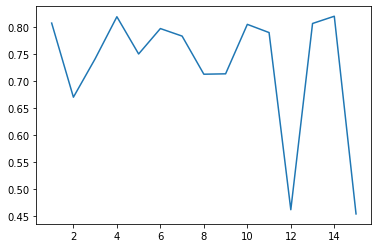

In [27]:
training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, EPOCHS, LOSS_FUNCTION, OPTIMIZER)

## Logistic Regression using Continuous Bag of Words Embedding

### Implement and Initialize the Classifier

In [31]:
class CBoWClassifier(nn.Module):
    def __init__(self, vecs_size, num_labels):
        super(CBoWClassifier, self).__init__()
        self.linear = nn.Linear(vecs_size, num_labels)
    
    def forward(self, cbow_vec):
        return F.log_softmax(self.linear(cbow_vec), dim=1)

model = CBoWClassifier(300, 2)

### Training

After epoch 1 the validation accuracy is 0.664.
After epoch 2 the validation accuracy is 0.539.
After epoch 3 the validation accuracy is 0.705.
After epoch 4 the validation accuracy is 0.777.
After epoch 5 the validation accuracy is 0.750.
After epoch 6 the validation accuracy is 0.616.
After epoch 7 the validation accuracy is 0.764.
After epoch 8 the validation accuracy is 0.754.
After epoch 9 the validation accuracy is 0.779.
After epoch 10 the validation accuracy is 0.707.
After epoch 11 the validation accuracy is 0.698.
After epoch 12 the validation accuracy is 0.524.
After epoch 13 the validation accuracy is 0.726.
After epoch 14 the validation accuracy is 0.565.
After epoch 15 the validation accuracy is 0.447.


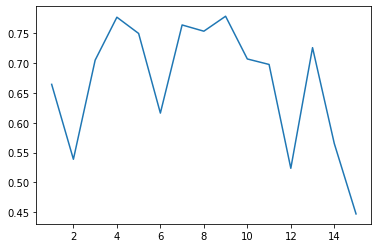

In [33]:
# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_cbow
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
EPOCHS = 15
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=2)

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, EPOCHS, LOSS_FUNCTION, OPTIMIZER)

### Scenario Analysis: Changing the Optimizer to Adam

After epoch 1 the validation accuracy is 0.608.
After epoch 2 the validation accuracy is 0.748.
After epoch 3 the validation accuracy is 0.763.
After epoch 4 the validation accuracy is 0.766.
After epoch 5 the validation accuracy is 0.771.
After epoch 6 the validation accuracy is 0.774.
After epoch 7 the validation accuracy is 0.776.
After epoch 8 the validation accuracy is 0.779.
After epoch 9 the validation accuracy is 0.782.
After epoch 10 the validation accuracy is 0.782.
After epoch 11 the validation accuracy is 0.786.
After epoch 12 the validation accuracy is 0.786.
After epoch 13 the validation accuracy is 0.786.
After epoch 14 the validation accuracy is 0.784.
After epoch 15 the validation accuracy is 0.786.


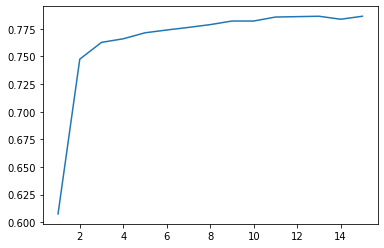

In [34]:
OPTIMIZER = torch.optim.Adam(model.parameters())
training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, EPOCHS, LOSS_FUNCTION, OPTIMIZER)